# **Benchmarking Goals**

**YOLO-NAS nano vs YOLOv8n (Nano):** Object Detection

**MiDaS vs OpenCV Stereo Depth:** Depth Perception

**Metrics to collect:**

            🔸 Object detection accuracy (mAP, precision, recall)

            🔸 Latency per frame (ms)

            🔸 CPU & RAM usage (for later on Pi 5)

# Drive mount and data retrieval

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Retrieving dataset

In [37]:
import os

# Define the directory path
download_dir = "/content/drive/MyDrive/SmartSight"

# Check if the folder exists and is not empty
if not os.path.exists(download_dir) or not os.listdir(download_dir):
    # If the folder does not exist or is empty, download the dataset
    !pip install roboflow
    from roboflow import Roboflow
    rf = Roboflow(api_key="RSm5lE1yTCyuCA8NxshW")
    project = rf.workspace("fpn").project("ood-pbnro")
    version = project.version(1)
    dataset = version.download("yolov8", location="/content/drive/MyDrive/SmartSight")
    print("Dataset downloaded!")
else:
    print(f"Dataset already exists in {download_dir}, skipping download.")

# Set the paths for further use
base_path = download_dir
yaml_path = base_path + '/data.yaml'

Dataset already exists in /content/drive/MyDrive/SmartSight, skipping download.


# Data Exploration

Counting images

In [3]:
import os

for split in ["train", "valid", "test"]:
    img_dir = os.path.join(base_path, split, "images")
    label_dir = os.path.join(base_path, split, "labels")

    num_imgs = len([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    print(f"{split.upper()} -> Images: {num_imgs}, Labels: {num_labels}")

TRAIN -> Images: 8000, Labels: 8000
VALID -> Images: 1000, Labels: 1000
TEST -> Images: 1000, Labels: 1000


Testing Bouding box

In [6]:
import yaml

# Load class names
with open(base_path+"/data.yaml", 'r') as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml['names']
print("Class names:", class_names)


Class names: ['bench', 'bicycle', 'bus', 'bus_stop', 'car', 'crutch', 'curb', 'dog', 'fire_hydrant', 'motorcycle', 'person', 'pole', 'spherical_roadblock', 'stairs', 'stop_sign', 'street_light', 'traffic_light', 'train', 'tree', 'truck', 'warning_column', 'waste_container']


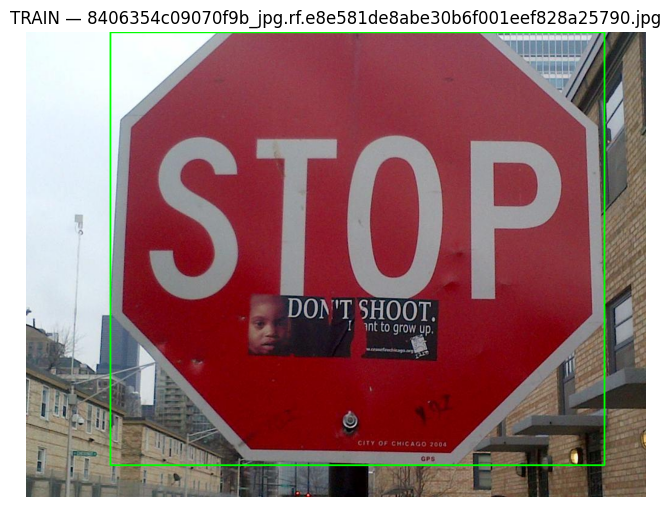

In [7]:
import cv2
import matplotlib.pyplot as plt
import random

def show_random_labeled_image(split="train"):
    img_dir = os.path.join(base_path, split, "images")
    label_dir = os.path.join(base_path, split, "labels")

    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    chosen_img = random.choice(img_files)

    img_path = os.path.join(img_dir, chosen_img)
    label_path = os.path.join(label_dir, os.path.splitext(chosen_img)[0] + ".txt")

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Draw labels
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
                x1 = int((x_center - box_w / 2) * w)
                y1 = int((y_center - box_h / 2) * h)
                x2 = int((x_center + box_w / 2) * w)
                y2 = int((y_center + box_h / 2) * h)

                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, f"Class {class_names[int(class_id)]}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"{split.upper()} — {chosen_img}")
    plt.axis('off')
    plt.show()

show_random_labeled_image("train")


# Object Detection Models

### Import Dependencies

In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [9]:
import torch
from ultralytics import YOLO
import cv2
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Train YOLOv8n

In [ ]:
import os
from ultralytics import YOLO

# Paths
drive_checkpoint_path = "/content/drive/MyDrive/SmartSight-Checkpoints/yolov8n_sights4/weights/best.pt"
local_checkpoint_path = "/content/best.pt"

In [34]:
# Check if model exists in Drive
if os.path.exists(drive_checkpoint_path):
    print("✅ Found trained model in Drive. Loading and resuming training...")

    # Copy to local path
    !cp "{drive_checkpoint_path}" "{local_checkpoint_path}"
    print("📦 Model copied to local path.")

    # Load model
    model = YOLO(local_checkpoint_path)

    # Resume training
    try:
        # Attempt to resume training
        model.train(resume=True)
    except Exception as e:
        # Check if the error message is about the model finishing training
        if 'training complete' in str(e).lower():  # Adjust this message based on the actual error message you get
            pass  # Do nothing if training is complete
        else:
            # If it's another error, print the exception message
            print(f"An error occurred: {e}")

else:
    print("❌ No trained model found. Starting training from scratch...")

    model = YOLO("yolov8n.pt")

    model.train(
        data=yaml_path,
        epochs=50,
        imgsz=640,
        batch=32,
        name='yolov8n_sights',
        save_period=5,
        project="/content/drive/MyDrive/SmartSight-Checkpoints"
    )


✅ Found trained model in Drive. Loading and resuming training...
📦 Model copied to local path.
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/best.pt, data=/content/OOD-1/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=/content/drive/My Drive/SmartSight-Checkpoints, name=yolov8n_sights45, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/content/best.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

### Export Model

In [11]:
from ultralytics import YOLO
model = YOLO('/content/best.pt')
model.export(format='onnx')

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,009,938 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 26, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.46', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 245.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 295.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 144.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 205.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 311.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 16.8s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim>=0.1.46', 'onnxruntime-gpu']
WARNING ⚠️ requirements: Restart runtime or rerun command for

'/content/best.onnx'

In [13]:
!cp best.onnx /content/drive/MyDrive/SmartSight

### Evaluate YOLOv8n

Load the model

In [35]:
model_path = download_dir + '/best.onnx'
onnx_model = YOLO(model_path)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


Get metrics

In [38]:
metrics = onnx_model.val(data=yaml_path)

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/drive/MyDrive/SmartSight/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 57.0±16.8 MB/s, size: 138.8 KB)


val: Scanning /content/drive/MyDrive/SmartSight/valid/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1000/1000 [00:34<00:00, 28.91it/s]


                   all       1000       2922       0.68      0.546       0.58      0.408
                 bench         65        117      0.734      0.538      0.612      0.363
               bicycle         37         57      0.549      0.555      0.514      0.354
                   bus         33         42      0.721      0.786      0.839      0.729
              bus_stop         34         35      0.657      0.714      0.697      0.557
                   car        166        392      0.713      0.574      0.634      0.469
                crutch         10         18      0.907      0.444       0.58      0.302
                  curb         27         70      0.371      0.386      0.295      0.211
                   dog         34         62      0.759      0.581      0.613      0.411
          fire_hydrant        117        138       0.86       0.71      0.769      0.565
            motorcycle         42         78      0.701      0.577      0.621      0.379
                perso

The model's performance is evaluated using **Precision (P)**, **Recall (R)**, **mAP50**, and **mAP50-95**.

- **Precision (P)**: How accurate the positive predictions are.
- **Recall (R)**: How well the model detects true positives.
- **mAP50**: Mean Average Precision at IoU 50%.
- **mAP50-95**: Average mAP across IoU thresholds from 50% to 95%.

- **Best performing classes**: Waste Container, Bus, Person, Traffic Light.

- **Speed**: Preprocessing: 0.8ms, Inference: 12.8ms, Post-processing: 3.1ms per image.

| Class              | Precision | Recall | mAP50 | mAP50-95 |
|--------------------|-----------|--------|-------|----------|
| **all**            | 0.68      | 0.546  | 0.58  | 0.408    |
| **bus**            | 0.721     | 0.786  | 0.839 | 0.729    |
| **waste_container**| 0.852     | 0.863  | 0.908 | 0.737    |
| **person**         | 0.478     | 0.326  | 0.317 | 0.182    |
| **traffic_light**  | 0.5       | 0.27   | 0.302 | 0.191    |






### Test YOLOv8n

Get random image


In [17]:
def get_random_image_from_dataset(dataset_path):
    # Get all image files in the dataset folder
    image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    # Randomly select an image
    random_image = random.choice(image_files)
    # Return the full path of the selected image
    return os.path.join(dataset_path, random_image)

Predict

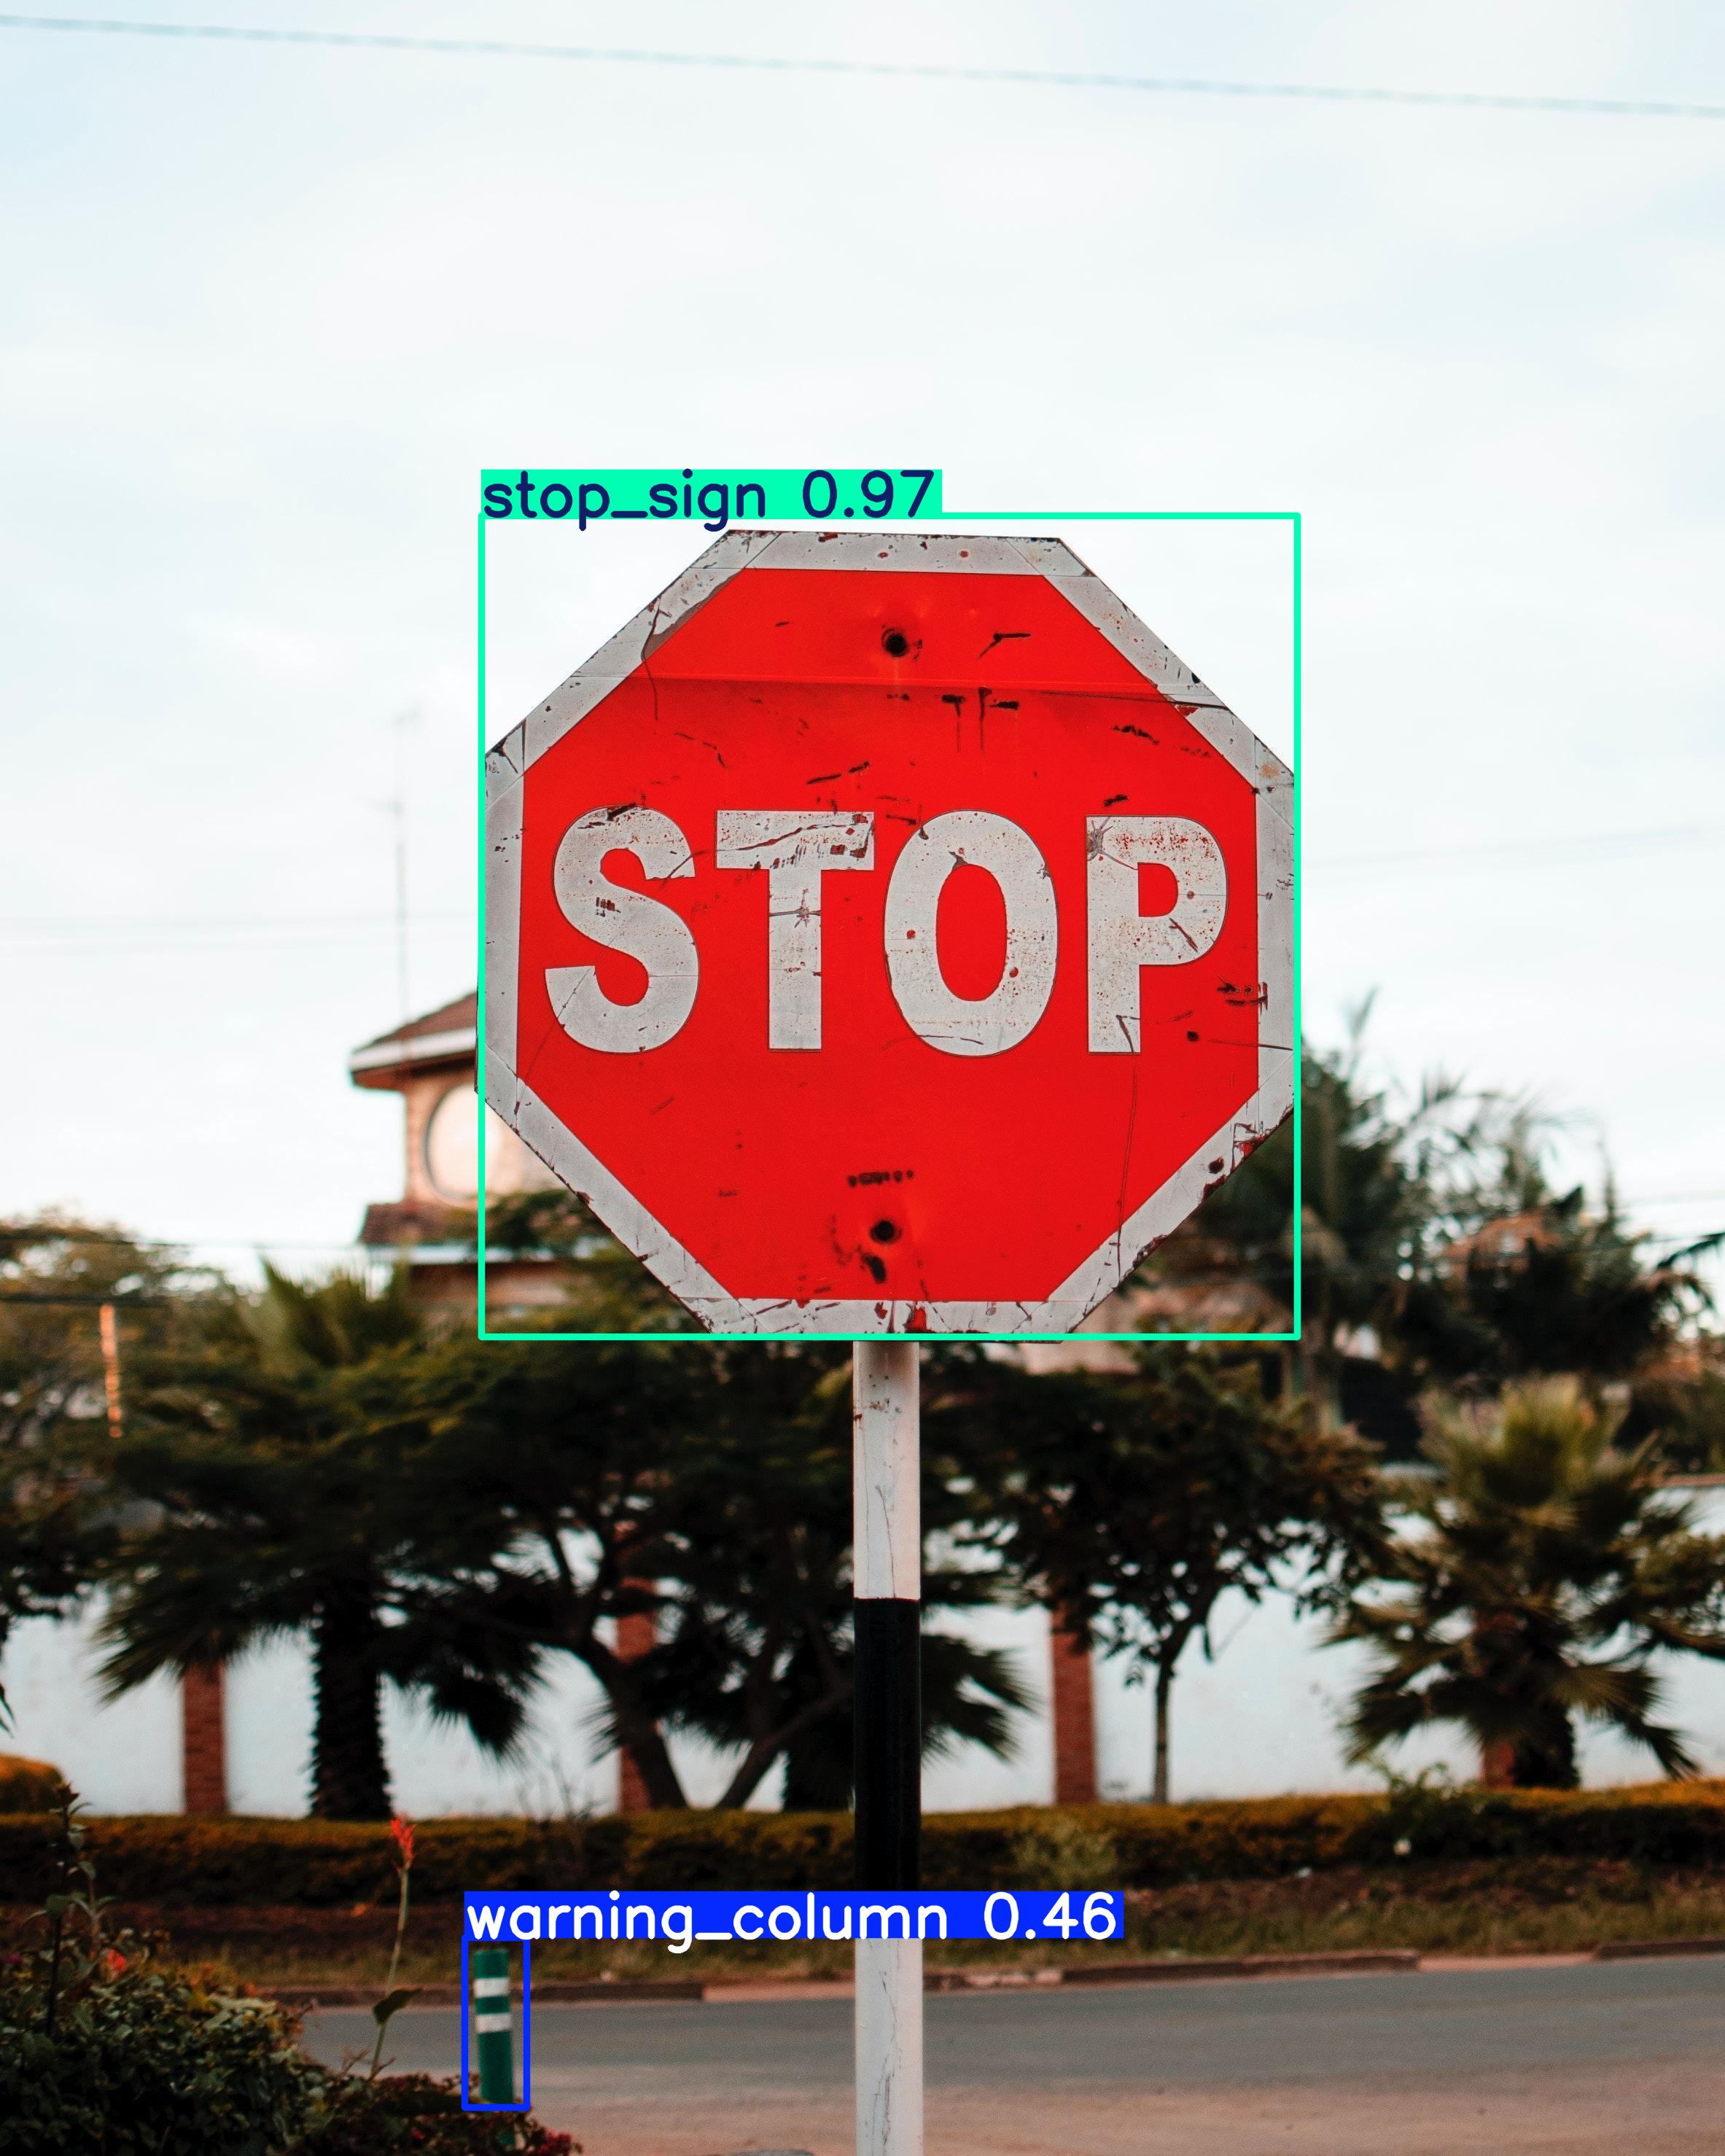

In [33]:
image_path = get_random_image_from_dataset('/content/drive/MyDrive/SmartSight/valid/images')
results = onnx_model(image_path)
result = results[0]

# Plot the results (image with bounding boxes)
result.show()